# Sprint 2, Module B

## Summary

Using a shapefile from Shaver Lake, we generated both population and sample treelists through the FastFuels platform. FastFuels is a 3D model of vegetation used primarily for the use in 3D fire models. FastFuels leverages multiple data sources including the Treemap project run by the United States Forest Service (USFS). The Treemap project is a model that has assigned a representative FIA plot for each 30 m2 area of the contiguous US. FastFuels is able to use the outputs of Treemap to simulate what trees might be found in any given location. 

By comparing the distributions of our results, we found that sample treelists tend to underrepresent smaller trees, likely due to non-random sampling biases and limited sample sizes. These discrepancies highlight the importance of comprehensive data collection for accurate forest structure modeling.

### Part 1: Building a Tree Sample

In [2]:
# We start by importing our main libraries
import geopandas as gpd
from utils.treemap import TreeMapConnection
import matplotlib.pyplot as plt
import zipfile
import os
import pandas as pd
import shutil

<Axes: >

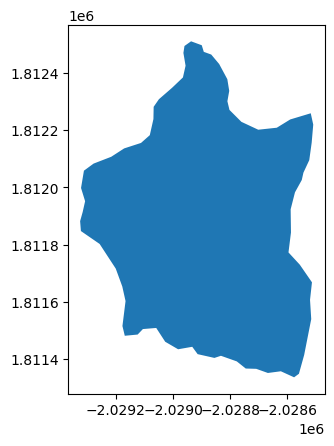

In [3]:
# First, we load our region of interest
roi = gpd.read_file("./shaver_lake_boundary.geojson")

roi_utm = roi.to_crs(5070) # We transform to UTM Coordinate Reference System (CRS).

roi_utm.plot()

In [4]:
version="2016" # There is 2014 version of TreeMap, that's why we specify that we are working with 2016
seed=123

# First, we establish a connection with the TreeMap2016 
treemap_connection = TreeMapConnection(
    treemap_path=f"https://wifire-data.sdsc.edu/data/treemap/TreeMap{version}.tif", # This is the remote URL
    tree_table_path=f"./utils/TreeMap{version}_tree_table.parquet",
    version=version,
)

# Now we extract our target raster, based on our Region of Interest
treemap_raster_extraction = treemap_connection.extract_window(
    roi_utm,
    projection_padding_meters=15 * treemap_connection.raster_resolution,
    interpolation_padding_cells=4,
)

# We extract the plots corresponding to that raster
treemap_plots = treemap_connection.get_plots_dataframe_from_raster(
    treemap_raster_extraction
)

# We generate a sample from the representative plots of our Region of Interest
tree_sample = treemap_connection.query_trees_by_plots(treemap_plots)

In [5]:
tree_sample.to_csv('tree_sample-shaverlake-Dream-Team!')

### Part 2: Comparing to Population

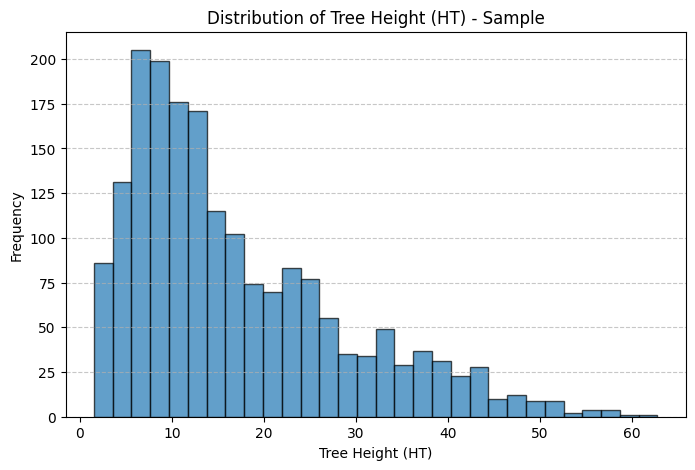

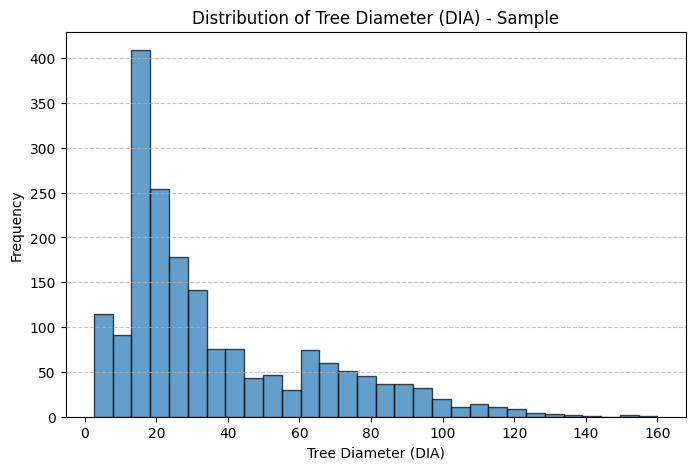

In [6]:
# Create a histogram for HT (Tree Height)
plt.figure(figsize=(8, 5))
plt.hist(tree_sample['HT'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Tree Height (HT)")
plt.ylabel("Frequency")
plt.title("Distribution of Tree Height (HT) - Sample")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Create a histogram for DIA (Tree Diameter)
plt.figure(figsize=(8, 5))
plt.hist(tree_sample['DIA'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Tree Diameter (DIA)")
plt.ylabel("Frequency")
plt.title("Distribution of Tree Diameter (DIA) - Sample")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
tree_population = tree_sample.expand_to_roi(
    "inhomogeneous_poisson",
    roi_utm,
    plots=treemap_plots,
    intensity_resolution=15,
    seed=seed,
)
tree_population.to_csv('tree_population-shaverlake-Dream-Team!')

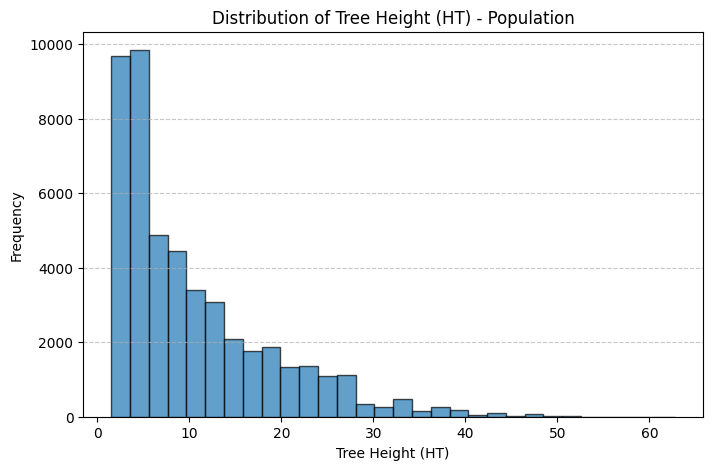

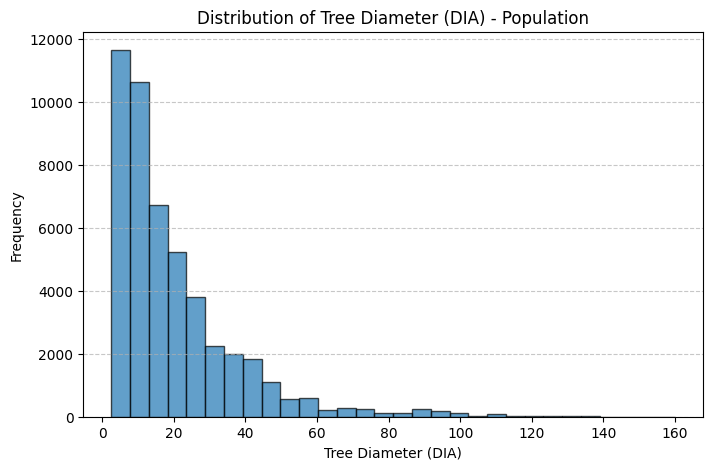

In [8]:
# Histogram for HT (Tree Height)
plt.figure(figsize=(8, 5))
plt.hist(tree_population['HT'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Tree Height (HT)")
plt.ylabel("Frequency")
plt.title("Distribution of Tree Height (HT) - Population")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Create a histogram for DIA (Tree Diameter)
plt.figure(figsize=(8, 5))
plt.hist(tree_population['DIA'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Tree Diameter (DIA)")
plt.ylabel("Frequency")
plt.title("Distribution of Tree Diameter (DIA) - Population")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Thoughts**: The main discrepancies between the sample and population treelists are likely due to sampling bias and sample size limitations. In both the height and diameter histograms, the population distributions are more heavily concentrated at the lower end of the scale, showing a higher frequency of smaller trees, while the sample histograms have relatively more mid to large-sized trees. This suggests that the sample may underrepresent smaller trees, which are more common in the population. Such discrepancies could result from non-random sampling. For instance, if larger trees were easier to detect, access, or were preferentially selected during sampling. Additionally, the smaller sample size inherently introduces more variability and is less likely to capture the full distributional shape of the population, especially in the tails. These factors combined lead to a sample distribution that is slightly shifted and more spread out compared to the true population distribution.